# Exogenous Processes

Exogenous processes are used in many structural models to embed dynamic features of the data which cannot be controlled by the individual like economic conditions (Diermeier et al. (2005)), layoffs (Behrman et al. (2016)) or job offer availability (Cohen-Goldner and Eckstein (2008)). The last two examples are arguably not completely exogenous which points to the second purpose of exogenous processes: simplifying the choice set. Although there are papers explicitly modeling the desire to have a child (Todd and Wolpin (2006)), most papers treat fertility as an exogenous process starting and ending at some age or a maximum number of children (Behrman et al. (2006)).

What does an exogenous process mean to the model? In models without exogenous processes the law of motion, the transition of states over periods, is deterministic. Given a state and a choice the state in the next period is certain. Exogenous processes introduce a stochastic element to the law of motion. Given a state and a choice there exist multiple states in the next period which are valid successors. The transition to one of the successors is determined by a probability which depends on the characteristics of the state.

For the solution of the structural model, this means that the continuation values have to be weighted by the probabilities of the exogenous process. In the simulation, one has to sample the new values of the exogenous process in the law of motion.

In the following, we will discuss three different kinds of exogenous processes.

1. Processes affecting the rewards of choices (economic conditions).
2. Processes affecting the availability of choices (job availability, retirement).
3. Processes with increasing characteristics (children).

In [1]:
import io

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import respy as rp

pd.set_option("display.max_rows", 100)

## 1. Processes affecting the rewards of choices

We start from the basic model of the Robinson Crusoe economy. Just to reiterate, Robinson is on an island and can choose between two alternatives every period. He can either go fishing and accumulate experience to become a better fisher or stay in the hammock.

We extend the basic model by representing Robinson's health with an exogenous process. For simplicity, we assume that the process has two outcomes. Robinson is either well or sick and only if he is sick, fishing is more difficult for him.

In [2]:
params, options = rp.get_example_model("robinson_crusoe_basic", with_data=False)params, options, and simulation

In [3]:
params

value
category       name                       
delta          delta                  0.95
wage_fishing   exp_fishing            0.30
nonpec_fishing constant              -0.20
nonpec_hammock constant               2.00
shocks_sdcorr  sd_fishing             0.50
               sd_hammock             0.50
               corr_hammock_fishing   0.00

First, we have to define the exogenous process. We assume that Robinson has a chance of 90% for being well in the next period and a 10% chance of being sick. Similar to the explanation on observables in [tutorial on the initial conditions](tutorial-initial-conditions.ipynb#Observables), we have to use the keyword `exogenous_process` to indicate that the following parameters belong to an exogenous process. `health` is used as the name of the exogenous process and `well` and `sick` are the potential values. With `probability` we indicate that the following value should be treated as a probability.

In [4]:
params.loc[("exogenous_process_health_well", "probability"), "value"] = 0.9
params.loc[("exogenous_process_health_sick", "probability"), "value"] = 0.1

Next, we amend the rewards and add a penalty to the working alternative fishing if Robinson is sick. We also need to add a covariate which defines what `sick` in `params` means, because, up to now, `sick` is only a potential value of the variable `health`, but not a variable itself.

In [5]:
params.loc[("nonpec_fishing", "sick"), "value"] = -2

In [6]:
options["covariates"]["sick"] = "health == 'sick'"

That's it. There nothing else to be done to define the process. But before we begin to simulate data, we have to define the distribution of `health` in the first period of the simulated data. Note that, the parameters under the keyword `exogenous_process` only define the transition probabilities. The parameters are only necessary for n-step-ahead simulation with sampling as explained in this [tutorial](tutorial-simulation.ipynb#1.-n-step-ahead-simulation-with-sampling). We can do this using the `observable` keyword and use the same probabilities as the process.

In [7]:
params.loc[("observable_health_well", "probability"), "value"] = 0.9
params.loc[("observable_health_sick", "probability"), "value"] = 0.1

In [8]:
simulate = rp.get_simulate_func(params, options)

In [9]:
df = simulate(params)

The following figure shows that the shares of health conditions are indeed replicated in the data.

<AxesSubplot:>

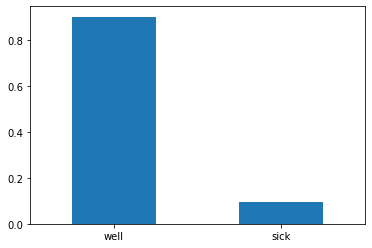

In [10]:
df["Health"].value_counts(normalize=True).plot.bar(rot=0)

Does the process affect the choices in the predicted way? The following figure shows that if Robinson is sick, choosing hammock is four times more likely than fishing.

<AxesSubplot:xlabel='Health'>

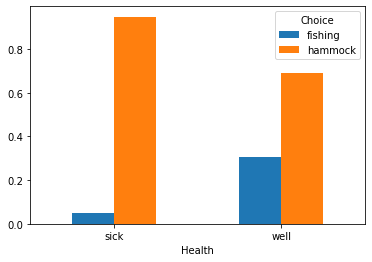

In [11]:
df.groupby("Health")["Choice"].value_counts(normalize=True).unstack().plot.bar(rot=0)

## 2. Processes affecting the availability of choices

Exogenous processes are also used to influence the choice set. As an example, let us further extend the model with an exogenous process of the weather. There is a 20% chance of a tropical storm which makes fishing impossible and an 80% chance of sunny weather which allows all activities. Note that, this process works simultaenously with the health process. There is not restriction regarding the number of exogenous processes.

Firstly, implement the transition probabilities.

In [12]:
params.loc[("exogenous_process_weather_tropical_storm", "probability"), "value"] = 0.2
params.loc[("exogenous_process_weather_sunny", "probability"), "value"] = 0.8

Then, use the `inadmissible_states` setting in the `options` to indicate which choices are not available. `inadmissible_states` is a dictionary where the keys are the choices. The values are lists of conditions which prevent an individual to choose the alternative if the statement is true. All statements are connected via the logical or and not and. Here, we prevent any individual from choosing fishing if there is a tropical storm.

In [13]:
options["inadmissible_states"] = {"fishing": ["weather == 'tropical_storm'"]}

In [14]:
simulate = rp.get_simulate_func(params, options)

/home/maxbl/Uni/OpenSourceEconomics/respy/package/respy/pre_processing/model_processing.py:216: UserWarning: The distribution of initial values for the exogenous process 'weather' is not defined in 'params'. Use the 'observable' keyword for this. This is only necessary for the n-step-ahead simulation. In the following, values are assumed to be equiprobable.
  warnings.warn(


Note that the warning is raised because we forgot to specify the distribution of `weather` in the first period.

In [15]:
df = simulate(params)

/home/maxbl/Uni/OpenSourceEconomics/respy/package/respy/pre_processing/model_processing.py:216: UserWarning: The distribution of initial values for the exogenous process 'weather' is not defined in 'params'. Use the 'observable' keyword for this. This is only necessary for the n-step-ahead simulation. In the following, values are assumed to be equiprobable.
  warnings.warn(


Below we see that realizations of `weather` are indeed equiprobable in the first period.

In [16]:
df.query("Period == 0").Weather.value_counts(normalize=True)

tropical_storm    0.511
sunny             0.489
Name: Weather, dtype: float64

We show the two figures from the health process first to show that this process has not changed.

<AxesSubplot:xlabel='Health'>

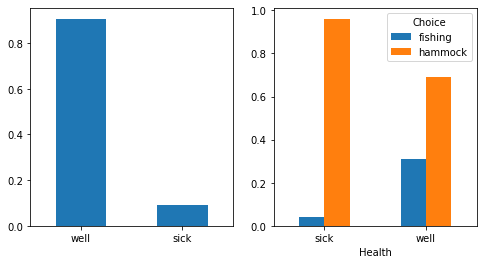

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

df["Health"].value_counts(normalize=True).plot.bar(ax=axs[0], rot=0)
df.groupby("Health")["Choice"].value_counts(normalize=True).unstack().plot.bar(
    ax=axs[1], rot=0
)

Secondly, we show the distribution of choices across weather conditions.

<AxesSubplot:xlabel='Weather'>

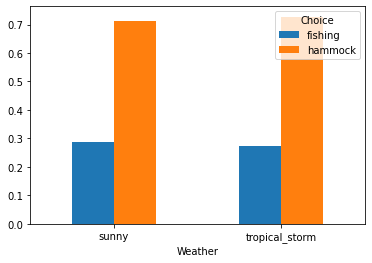

In [18]:
df.groupby("Weather")["Choice"].value_counts(normalize=True).unstack().plot.bar(rot=0)

## 3. Processes with increasing characteristics

At last, we implement a more complex exogenous process which can be used to model the desire to have a child instead of including it in the choice set. As this feature is frequently used in structural models analyzing female labor force participation (Behrman et al. (2016), Blundell et al. (2016)), we focus on Robin Kreutzner, Robinson's half sister, who shares the same father, a Bremen merchant. She lives in York during the 17th century and works in a weaving mill. Starting with the age of 20, there is a chance that Robin becomes pregnant and gives birth to one or two children in one period for the following 30 periods. As child care is extremely underdeveloped at that time and her mother cannot take care of the children every time, working at the weaving mill becomes more difficult for her with every child.

The main difference of such a process in contrast to others is that in each state not all potential values of the process are available. We assume that the number of children can only increase, meaning there is no child death. Although singleton pregancies are the most common form of pregancies, we also allow for twins with a very small probability.

The following cell contains the basic parameterization of the model. There is one working alternative, `weaving`, and one non-working alternative, `home`.

In [19]:
params = pd.read_csv(
    io.StringIO(
        """
category,name,value
delta,delta,0.95
wage_weaving,exp_weaving,0.1
nonpec_weaving,constant,-1
nonpec_weaving,children,-5
nonpec_home,constant,2.5
shocks_sdcorr,sd_weaving,1
shocks_sdcorr,sd_home,1
shocks_sdcorr,corr_home_weaving,-0.2
"""
    ),
    index_col=["category", "name"],
)

options = {
    "n_periods": 30,
    "covariates": {"constant": "1"},
}

Next, we will define the process for this very artificial example. The main reason why the following distribution is so complex is that the process has to be defined going from a certain number of children to another number of children. Note that, all parameters are coefficients of an multinomial logit as explained in the [tutorial on the initial conditions](tutorial-initial-conditions.ipynb#Lagged-Choices).

The general idea for the transition probabilities is as follows:

- The number of children cannot reduce.
- Up to the third child, there is a ...
  - 90% chance of having no additional child
  - 9% chance of having one additional child
  - 1% chance of having two additional children
  
  ... in the next period.
- Beyond the third child, there is a ...
  - 98% chance of having no additional child
  - 1.9% chance of having one additional child
  - 0.1% chance of having two additional children
  
  ... in the next period.
- No one has more than six children.

Let us take a look at the first set of parameters. Under `exogenous_process_children_0` we specify the transition probabilities from any state with any number of children to a state with no children at all. The first parameter `has_children` adds a huge negative penalty in case the state has children. Thus, the transition probability from any state with children to a state with zero children is zero. For states with zero children, we want to have a 90% chance of having no children in the next period as well. Thus, we use $\log 0.9 \approx -1.05$ as the parameter value. (The trick is also explained in the tutorial.)

In [20]:
params.loc[("exogenous_process_children_0", "no_children"), "value"] = -0.105
params.loc[("exogenous_process_children_0", "has_children"), "value"] = -1e300

To define the transition to having one child, we use $-2.408 \approx \log 0.09$ as the parameter for a state with no children. $-0.105 \approx \log 0.9$ ensures that with 90% chance, there is no additional child for states with already one child. The huge penalty for `more_than_one_child` ensures that there is no backward motion.

In [21]:
params.loc[("exogenous_process_children_1", "no_children"), "value"] = -2.408
params.loc[("exogenous_process_children_1", "one_child"), "value"] = -0.105
params.loc[("exogenous_process_children_1", "more_than_one_child"), "value"] = -1e300

Next, we define the transition to states with two children. The majority of the parameters is analogously defined to the former explanations. But, note that the first parameter specifies the transition from states with no children to states with two children and therefore the possibility of having twins. The parameter value is $-4.605 = \log 0.01$.

In [22]:
params.loc[("exogenous_process_children_2", "no_children"), "value"] = -4.605
params.loc[("exogenous_process_children_2", "one_child"), "value"] = -2.408
params.loc[("exogenous_process_children_2", "two_children"), "value"] = -0.105
params.loc[("exogenous_process_children_2", "more_than_two_children"), "value"] = -1e300

params.loc[("exogenous_process_children_3", "no_children"), "value"] = -1e300
params.loc[("exogenous_process_children_3", "one_child"), "value"] = -4.605
params.loc[("exogenous_process_children_3", "two_children"), "value"] = -2.408
params.loc[("exogenous_process_children_3", "three_children"), "value"] = -0.105
params.loc[
    ("exogenous_process_children_3", "more_than_three_children"), "value"
] = -1e300

As discussed before the transition probabilities to states with at least four children change.

In [23]:
params.loc[("exogenous_process_children_4", "less_than_two_children"), "value"] = -1e300
params.loc[("exogenous_process_children_4", "two_children"), "value"] = -6.908
params.loc[("exogenous_process_children_4", "three_children"), "value"] = -3.963
params.loc[("exogenous_process_children_4", "four_children"), "value"] = -0.02
params.loc[
    ("exogenous_process_children_4", "more_than_four_children"), "value"
] = -1e300

params.loc[
    ("exogenous_process_children_5", "less_than_three_children"), "value"
] = -1e300
params.loc[("exogenous_process_children_5", "three_children"), "value"] = -6.908
params.loc[("exogenous_process_children_5", "four_children"), "value"] = -3.963
params.loc[("exogenous_process_children_5", "five_children"), "value"] = -0.02
params.loc[("exogenous_process_children_5", "six_children"), "value"] = -1e300

params.loc[
    ("exogenous_process_children_6", "less_than_four_children"), "value"
] = -1e300
params.loc[("exogenous_process_children_6", "four_children"), "value"] = -6.908
params.loc[("exogenous_process_children_6", "five_children"), "value"] = -3.963

At last, we need to specify that all Robins start with no children.

In [24]:
params.loc[("observable_children_0", "probability"), "value"] = 1
params.loc[("observable_children_1", "probability"), "value"] = 0
params.loc[("observable_children_2", "probability"), "value"] = 0
params.loc[("observable_children_3", "probability"), "value"] = 0
params.loc[("observable_children_4", "probability"), "value"] = 0
params.loc[("observable_children_5", "probability"), "value"] = 0
params.loc[("observable_children_6", "probability"), "value"] = 0

The many covariates are defined here and added to the `options` of the model.

In [25]:
options["covariates"].update(
    {
        "no_children": "children == 0",
        "has_children": "children > 0",
        "one_child": "children == 1",
        "more_than_one_child": "children > 1",
        "two_children": "children == 2",
        "less_than_two_children": "children < 2",
        "more_than_two_children": "children > 2",
        "three_children": "children == 3",
        "less_than_three_children": "children < 3",
        "more_than_three_children": "children > 3",
        "four_children": "children == 4",
        "less_than_four_children": "children < 4",
        "more_than_four_children": "children > 4",
        "five_children": "children == 5",
        "six_children": "children == 6",
    }
)

Let us simulate the data!

In [26]:
simulate = rp.get_simulate_func(params, options)
df = simulate(params)

Firstly, we take a look at the final distribution of children in the last period.

<AxesSubplot:>

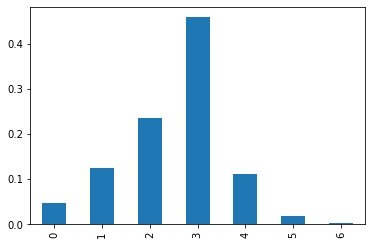

In [27]:
df.query("Period == Period.max()").Children.value_counts(
    normalize=True
).sort_index().plot.bar()

Secondly, we take a look at the transitions from the previous number of children to the value in the next period.

In [28]:
df["Prev_Children"] = df.groupby("Identifier")["Children"].transform("shift")
pd.crosstab(df.Prev_Children, df.Children)

Children,0,1,2,3,4,5,6
Prev_Children,,,,,,,
0.0,8756,858,94,0,0,0,0
1.0,0,6498,656,78,0,0,0
2.0,0,0,5150,509,5,0,0
3.0,0,0,0,5211,121,8,0
4.0,0,0,0,0,938,14,0
5.0,0,0,0,0,0,90,4
6.0,0,0,0,0,0,0,10


At last, we plot the choice probabilities versus the number of children. As expected, a higher number of children is correlated with choosing `home` because of the penalty in the non-pecuniary rewards of `weaving`.

<AxesSubplot:xlabel='Children'>

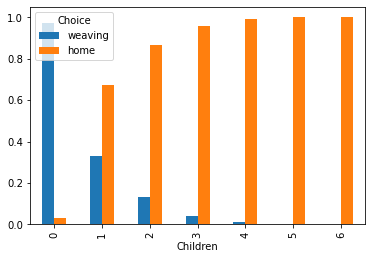

In [29]:
df.groupby("Children")["Choice"].value_counts(normalize=True).unstack().plot.bar()

## Notes for the estimation

The example for the exogenous process for children required many parameters which are not directly suited for estimation. Part of the parameters, the penalties, only exist to give structure to the process and turn a general exogenous process where all values are accessible all the time to an incrementing process. During the estimation of the model, these parameters should be fixed such that the optimizer does not accidentally redefine the process.

Another part of the parameters is repetitive for the groups up to three children and beyond. If the parameters should have the same value, use `estimagic`'s [equality constraints](https://estimagic.readthedocs.io/en/latest/optimization/constraints/constraints.html#equality-constraints). This ensures that the optimizer only sees one parameter instead of all similar parameters.

## References

> Behrman, J. R., Tincani, M. M., Todd, P. E., & Wolpin, K. I. (2016). [Teacher quality in public and private schools under a voucher system: The case of Chile.](https://scholarship.rice.edu/bitstream/handle/1911/94185/Teacher-Quality-Chile.pdf) *Journal of Labor Economics, 34*(2), 319-362.

> Blundell, R., Costa Dias, M., Meghir, C., & Shaw, J. (2016). [Female labor supply, human capital, and welfare reform.](https://www.nber.org/papers/w19007.pdf) *Econometrica, 84*(5), 1705-1753.

> Cohen‐Goldner, S., & Eckstein, Z. (2008). [Labor mobility of immigrants: Training, experience, language, and opportunities.](https://www.econstor.eu/bitstream/10419/21422/1/dp519.pdf) *International Economic Review, 49*(3), 837-872.

> Diermeier, D., Keane, M., & Merlo, A. (2005). [A political economy model of congressional careers.](https://www.econstor.eu/bitstream/10419/31182/1/586098267.PDF) *American Economic Review, 95*(1), 347-373.

> Todd, P. E., & Wolpin, K. I. (2006). [Assessing the impact of a school subsidy program in Mexico: Using a social experiment to validate a dynamic behavioral model of child schooling and fertility.](https://pdfs.semanticscholar.org/5176/d1142bee77741599114ca4f661ddfa5c5101.pdf) *American economic review, 96*(5), 1384-1417.